# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [3]:
# %run "Git.ipynb".ipynb

In [4]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [7]:

Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [10]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [11]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
# trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))


In [14]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [15]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [16]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_55184\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [17]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [18]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()

In [407]:
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100

pnl.sort_values(ascending=False,by='Price in USDT').round(2)


,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,2314.47,2238.72,1.00,-176.97,101.22,-75.75,-3.27
BTCUSDT,601.02,1046.65,0.47,3.54,445.63,449.17,19.41
SOLUSDT,281.20,349.49,0.16,0.00,68.29,68.29,2.95
ETHUSDT,250.75,316.36,0.14,0.00,65.61,65.61,2.83
JASMYUSDT,387.46,216.84,0.10,0.00,-170.62,-170.62,-7.37
TRXUSDT,76.87,170.81,0.08,-10.72,93.94,83.22,3.60
OMUSDT,526.32,120.78,0.05,0.00,-405.54,-405.54,-17.52
BNBUSDT,13.87,17.78,0.01,-10.61,3.91,-6.70,-0.29
BBUSDT,0.01,0.00,0.00,-84.82,-0.00,-84.82,-3.66
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52,-1.66


In [21]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

125

In [22]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [23]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [24]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [25]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [26]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [27]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [29]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 296b90f526b736d7b59b313b4961c6a1c10e6d84)
✅ File pushed/updated successfully!


In [30]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [31]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [32]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [33]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: dc55ef54bbba581d3650f9cb343f23c7ee8b153f)
✅ File pushed/updated successfully!


In [34]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [35]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [36]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [37]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [38]:
# pnl_history['Total']

In [39]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [40]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [41]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [366]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [368]:
pnl_history['Total']

2024-09-23   -242.846960
2024-09-24   -351.229838
2024-09-25   -362.331965
2024-09-26   -276.632747
2024-09-27   -260.113627
                 ...    
2025-08-12   -166.937050
2025-08-13   -101.896776
2025-08-14   -218.841594
2025-08-15   -252.630296
2025-08-16     65.642239
Name: Total, Length: 328, dtype: float64

<Axes: >

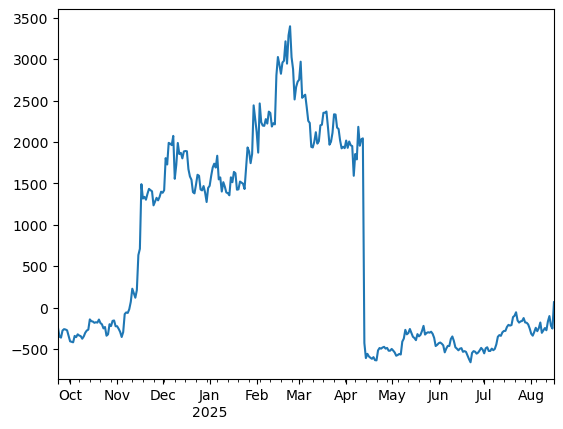

In [370]:
pnl_history['Total'].plot()

In [372]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-30:]

2025-07-18     -8.924780
2025-07-19      6.695876
2025-07-20     95.941730
2025-07-21     16.674338
2025-07-22     41.891706
2025-07-23    -99.585907
2025-07-24    -25.169421
2025-07-25     14.611312
2025-07-26      4.924152
2025-07-27     35.123826
2025-07-28    -52.773000
2025-07-29     -3.735193
2025-07-30    -20.315121
2025-07-31    -49.767968
2025-08-01    -62.484839
2025-08-02    -23.659997
2025-08-03     44.829219
2025-08-04     50.440091
2025-08-05    -41.020054
2025-08-06     36.413389
2025-08-07     68.439267
2025-08-08   -124.710668
2025-08-09     28.638649
2025-08-10     28.580156
2025-08-11    -26.126058
2025-08-12    106.411481
2025-08-13     65.040275
2025-08-14   -116.944819
2025-08-15    -33.788702
2025-08-16    318.272535
Name: Total, dtype: float64

In [46]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-371.35019028391105, -950.5160328166933)

In [47]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [48]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [49]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [50]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [51]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [52]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [53]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

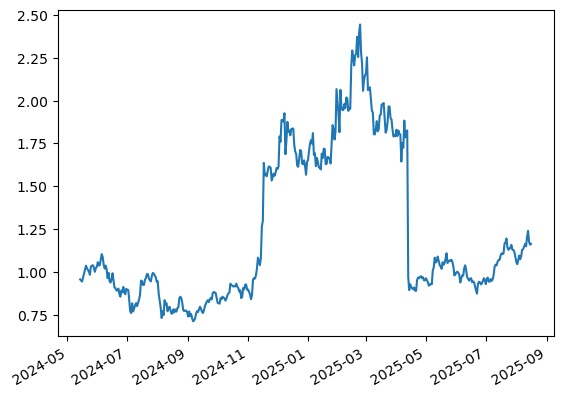

In [54]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

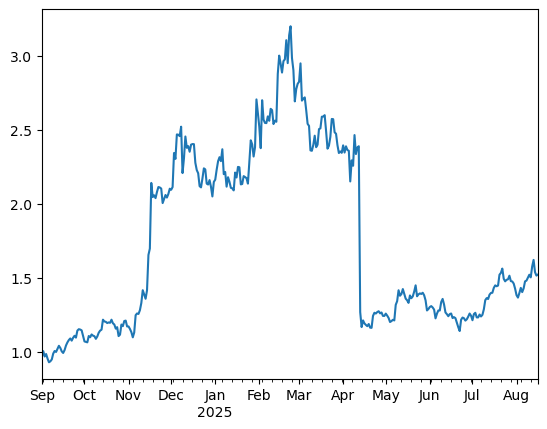

In [55]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [57]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [374]:
days=30
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [376]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [380]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.4110
TRXUSDT,0.3174
ETHUSDT,0.1741
ADAUSDT,0.0975
LINKUSDT,0.0000
BCHUSDT,0.0000
PEPEUSDT,0.0000
JASMYUSDT,0.0000
DOGEUSDT,0.0000
SUIUSDT,0.0000


In [382]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.458745
TRXUSDT,0.366609
ETHUSDT,0.164754
LTCUSDT,0.009892


In [384]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

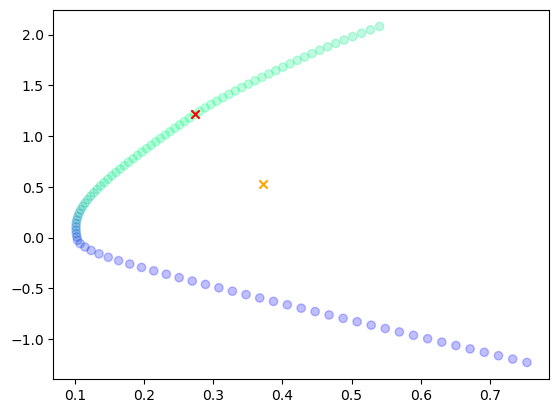

In [386]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [387]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [388]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1045.5603,0.4697,0.0000,0.4697
SOLUSDT,344.4633,0.1547,0.0000,0.1547
ETHUSDT,314.1935,0.1411,0.0824,0.0587
JASMYUSDT,214.1532,0.0962,0.0000,0.0962
TRXUSDT,170.6140,0.0766,0.1834,-0.1068
OMUSDT,119.5256,0.0537,0.0000,0.0537
BNBUSDT,17.7251,0.0080,0.2293,-0.2213
BBUSDT,0.0015,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
PAXGUSDT,0.0000,0.0000,0.0000,0.0000


### Current results

In [391]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [395]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BNBUSDT,0.462006
TRXUSDT,0.366288
ETHUSDT,0.171706


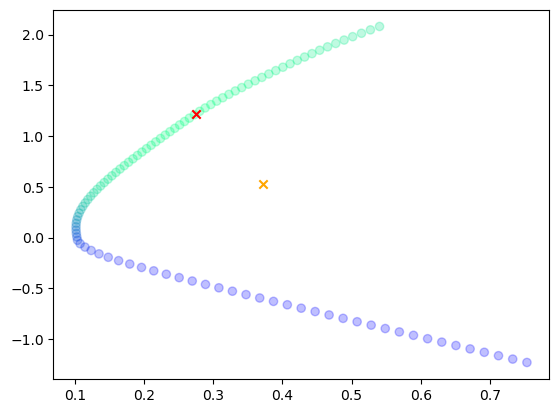

In [396]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [397]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1045.5603,0.4697,0.0000,0.4697
SOLUSDT,344.4633,0.1547,0.0000,0.1547
ETHUSDT,314.1935,0.1411,0.1717,-0.0306
JASMYUSDT,214.1532,0.0962,0.0000,0.0962
TRXUSDT,170.6140,0.0766,0.3663,-0.2897
OMUSDT,119.5256,0.0537,0.0000,0.0537
BNBUSDT,17.7251,0.0080,0.4620,-0.4540
BBUSDT,0.0015,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000


# Risk Reward Analysis

In [76]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [77]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

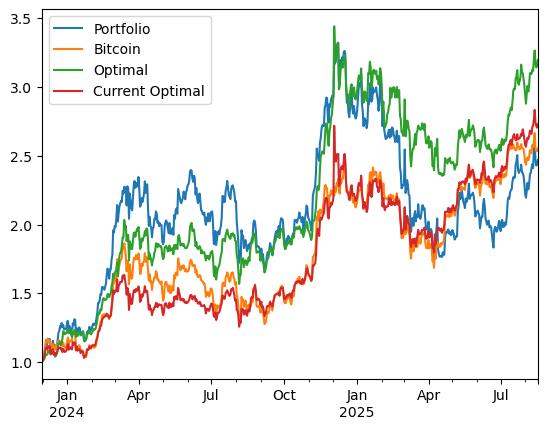

In [78]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [79]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

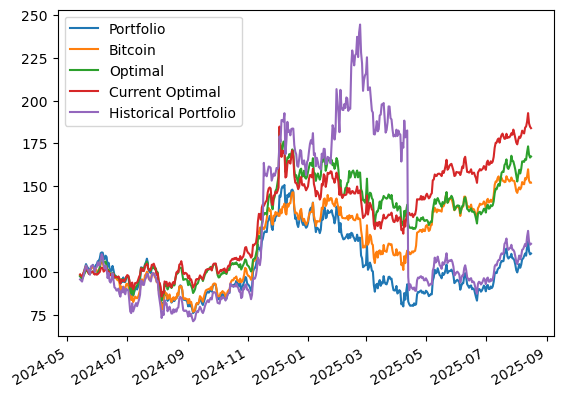

In [80]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


In [81]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-08-07,107.427759,152.431029,164.497348,182.424838,112.908559
2025-08-08,107.803718,151.392970,164.425686,181.507442,113.269675
2025-08-09,109.294651,151.116999,164.199639,180.797537,114.803097
2025-08-10,110.726194,154.747423,165.845222,184.193351,116.313837
2025-08-11,109.429201,153.956700,165.408632,184.862822,114.941611
2025-08-12,114.697318,155.823749,169.870477,187.699418,120.542351
2025-08-13,117.932690,159.885155,173.264256,192.663965,123.941736
2025-08-14,111.940340,153.251473,168.379558,186.626522,117.649222
2025-08-15,110.220702,152.011808,166.710006,184.739813,115.859840
2025-08-16,110.692800,152.061818,167.333656,183.883411,116.362675


## Volatilities

In [83]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.376911
 dtype: float64,
 0.37721020451024845)

In [84]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.469339
 dtype: float64,
 0.46933935029569607)

In [85]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.470631
Bitcoin            0.407456
Optimal            0.377210
Current Optimal    0.370782
dtype: float64

In [86]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.5336271629838248

In [ ]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

<Axes: >

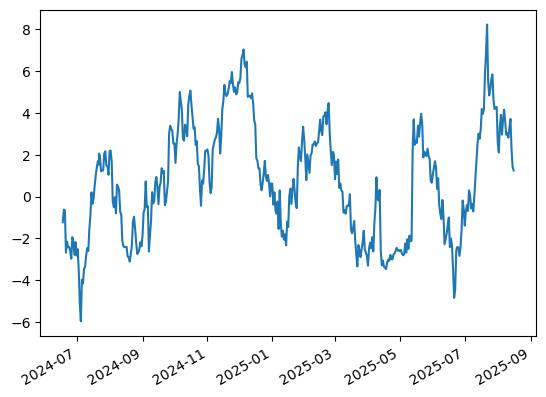

In [451]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [88]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.49358047255720056

## Risk Contribution

In [90]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,75.9210,0.3820,0.2017,0.1803
WBTCUSDT,40.7859,0.2232,0.0785,0.1447
TRXUSDT,25.9592,0.1755,0.0888,0.0867
XRPUSDT,21.9899,0.1443,0.0471,0.0971
SUIUSDT,0.5943,0.0067,0.0001,0.0066
OMUSDT,-38.2639,0.0684,0.0291,0.0392
Portfolio,126.9863,1.0000,0.4454,0.5546


In [91]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,41.436921,0.527421,0.443951,0.083469
TRXUSDT,35.187112,0.472579,0.389110,0.083469
Portfolio,76.624033,1.000000,0.833061,0.166939


In [92]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,30.134590,0.348787,0.149137,0.199650
TRXUSDT,7.958162,0.041677,0.012642,0.029034
ETHUSDT,1.625703,0.152590,0.031624,0.120967
BNBUSDT,0.248467,0.006588,0.000075,0.006514
SOLUSDT,-2.440432,0.193720,0.049614,0.144106
JASMYUSDT,-6.502706,0.177603,0.048995,0.128609
OMUSDT,-8.067129,0.079034,0.034480,0.044554
Portfolio,22.956654,1.000000,0.326566,0.673434


# Value At Risk

## Historical

### Optimal Weights

In [96]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.06500129883698066, -0.08153072208358532)

### Current Weights

In [98]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.08113841078318113, -0.0976868988537559)

In [99]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [100]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.030910
SOLUSDT     -0.011960
ETHUSDT     -0.012150
JASMYUSDT   -0.017162
TRXUSDT     -0.003934
OMUSDT      -0.002842
BNBUSDT     -0.000670
BBUSDT      -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.079628
Name: 2025-03-09 00:00:00, dtype: float64

In [101]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.025445
SOLUSDT     -0.018120
ETHUSDT     -0.013950
JASMYUSDT   -0.013528
TRXUSDT     -0.004212
OMUSDT      -0.018794
BNBUSDT     -0.000629
BBUSDT       0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.094677
dtype: float64

## Parametric

### Optimal Weights

In [104]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.05527869995812469, -0.06846628599134319)

### Current Weights

In [106]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.0687798707811259, -0.08518836924376812)

## Multivariate

### Optimal Weights

In [109]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.053196467726772584, -0.06139563531036224)

### Current Weights

In [111]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06659907534808021, -0.07651182252361499)

In [112]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.023854
SOLUSDT     -0.013167
ETHUSDT     -0.010081
JASMYUSDT   -0.010771
TRXUSDT     -0.002985
OMUSDT      -0.006370
BNBUSDT     -0.000428
Portfolio   -0.067655
dtype: float64

In [113]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.025538
SOLUSDT     -0.012401
ETHUSDT     -0.010602
JASMYUSDT   -0.011031
TRXUSDT     -0.002994
OMUSDT      -0.005510
BNBUSDT     -0.000422
Portfolio   -0.068498
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [117]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05155069468134898, -0.05922992796648954)

### Current Weights

In [119]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06769362034605549, -0.07810822055686215)

In [120]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [123]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05406524838706733, -0.06207488798206083)

### Current Weights

In [125]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07060199163647352, -0.08138511731314971)

In [126]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [129]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.08457279013342647, -0.10085408960950418)

### Current Weights

In [131]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.08528562990231164, -0.10484321414547404)

In [132]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [135]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [136]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0574291935061435, -0.06530919529126827)

### Current Weights

In [138]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06967308391246753, -0.08062500661806968)

In [139]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [140]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.027114,-0.023248,-0.016977,-0.023854,-0.023880
SOLUSDT,-0.010358,-0.012862,-0.009024,-0.013167,-0.013902
ETHUSDT,-0.003556,-0.010640,-0.007560,-0.010081,-0.010547
JASMYUSDT,-0.009108,-0.012223,-0.009212,-0.010771,-0.013117
TRXUSDT,-0.001628,-0.002678,-0.002347,-0.002985,-0.002875
OMUSDT,-0.005832,-0.005758,-0.004030,-0.006370,-0.004985
BNBUSDT,0.000061,-0.000465,-0.000339,-0.000428,-0.000481
Portfolio,-0.057536,-0.067874,-0.049489,-0.067655,-0.069787


In [141]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.025267,-0.023850,-0.016730,-0.025538,-0.024252
SOLUSDT,-0.011400,-0.013179,-0.008946,-0.012401,-0.013704
ETHUSDT,-0.003612,-0.010773,-0.007821,-0.010602,-0.010195
JASMYUSDT,-0.009695,-0.012252,-0.009363,-0.011031,-0.014245
TRXUSDT,-0.001422,-0.002726,-0.002764,-0.002994,-0.003198
OMUSDT,-0.006950,-0.005530,-0.004107,-0.005510,-0.004824
BNBUSDT,0.000072,-0.000477,-0.000336,-0.000422,-0.000483
Portfolio,-0.058274,-0.068787,-0.050067,-0.068498,-0.070902


## VaR Violation

In [143]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.031080,-0.040349,-0.033946,0.007167
2023-12-31,-0.031080,-0.040479,-0.034243,-0.001393
2024-01-01,-0.031080,-0.040688,-0.034833,0.016373
2024-01-02,-0.031080,-0.040624,-0.034033,0.005904
2024-01-03,-0.031080,-0.041581,-0.036872,-0.021462
...,...,...,...,...
2025-08-13,-0.027404,-0.040275,-0.034932,0.019979
2025-08-14,-0.029004,-0.042352,-0.037759,-0.028192
2025-08-15,-0.029004,-0.041938,-0.038586,-0.009915
2025-08-16,-0.029004,-0.040581,-0.038412,0.003741


In [144]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.024129,-0.077904,-0.067356,-0.016107
2024-05-29,-0.017794,-0.075851,-0.067936,-0.009083
2024-05-30,-0.017794,-0.064094,-0.056516,0.023958
2024-05-31,-0.017794,-0.062980,-0.056333,0.006014
2024-06-01,-0.017794,-0.061358,-0.055367,0.015733
...,...,...,...,...
2025-08-13,-0.030492,-0.054646,-0.049524,0.028208
2025-08-14,-0.048126,-0.064063,-0.059688,-0.050812
2025-08-15,-0.048126,-0.062908,-0.057668,-0.015362
2025-08-16,-0.046582,-0.058580,-0.052510,0.004283


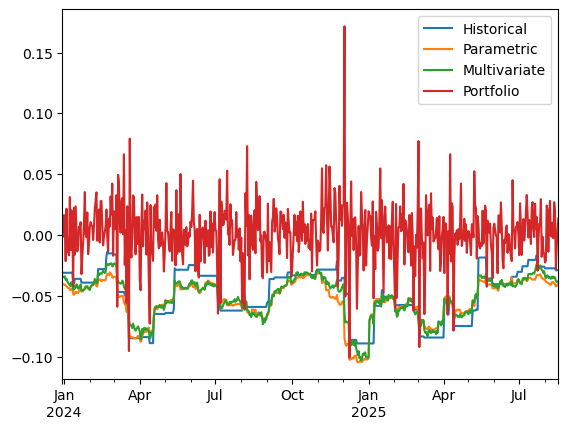

In [145]:
var_data.plot()
plt.show()

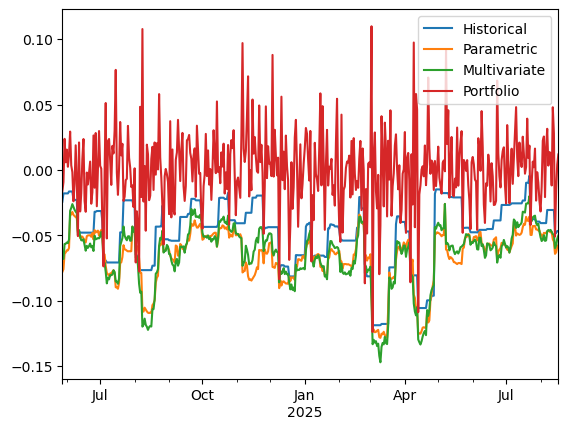

In [146]:
current_var_data.plot()
plt.show()


In [147]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.031826,0.018425,0.01675
Kupiec Stat,4.739915,16.357307,18.51478
P-value,0.029471,0.000052,0.000017


In [148]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064877,0.017897,0.01566
Kupiec Stat,1.911918,12.741395,14.995469
P-value,0.16675,0.000358,0.000108


# Principal Component Analysis

## Historical PCA

In [151]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.58347742, 0.23080204, 0.07737116, 0.05984832, 0.04850105])

In [152]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

ADAUSDT      0.062162
AVAXUSDT     0.062617
BCHUSDT      0.047622
BNBUSDT      0.027618
BTCUSDT      0.031852
DOGEUSDT     0.065171
ETHUSDT      0.045594
HBARUSDT     0.063114
JASMYUSDT    0.072917
LINKUSDT     0.058284
LTCUSDT      0.044003
OMUSDT       0.072084
PAXGUSDT     0.000492
PEPEUSDT     0.083167
SOLUSDT      0.055024
SUIUSDT      0.060913
TRXUSDT      0.018342
USDCUSDT    -0.000159
WBTCUSDT     0.031628
XLMUSDT      0.049556
XRPUSDT      0.047998
Name: PC1, dtype: float64

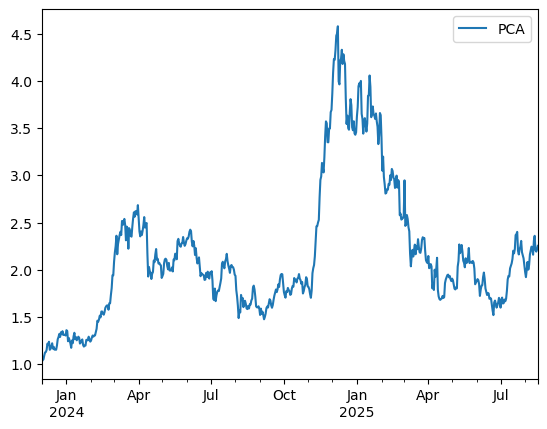

In [153]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

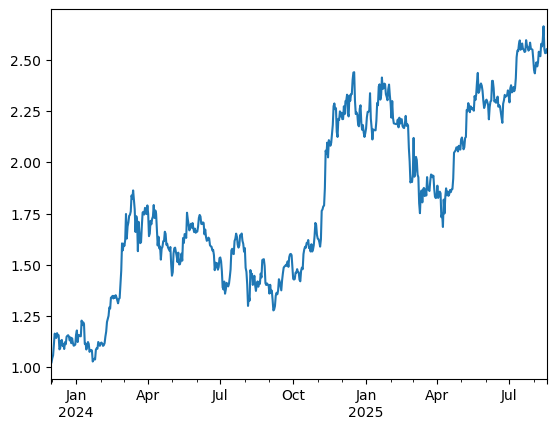

In [154]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [155]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.531294
WBTCUSDT     0.563068
BTCUSDT      0.563594
AVAXUSDT     0.671062
SOLUSDT      0.677438
LINKUSDT     0.687702
DOGEUSDT     0.697850
LTCUSDT      0.719560
BNBUSDT      0.720268
ADAUSDT      0.734728
XRPUSDT      0.769042
BCHUSDT      0.839012
XLMUSDT      0.904926
USDCUSDT     0.958530
PAXGUSDT     0.971822
SUIUSDT      1.073743
TRXUSDT      1.087799
HBARUSDT     1.100370
JASMYUSDT    1.215470
dtype: float64

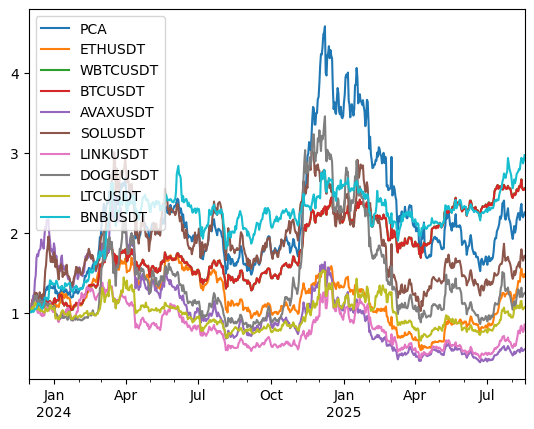

In [156]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

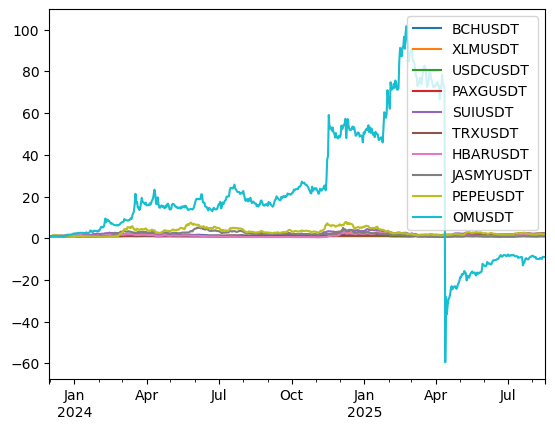

In [157]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [159]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.52451436, 0.30208254, 0.06895793, 0.06302252, 0.04142265])

In [160]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.049570
SOLUSDT      0.092964
ETHUSDT      0.080928
JASMYUSDT    0.141709
TRXUSDT      0.034391
OMUSDT       0.240534
BNBUSDT      0.051101
BBUSDT       0.170199
PEPEUSDT     0.137572
PAXGUSDT     0.001033
Name: PC1, dtype: float64

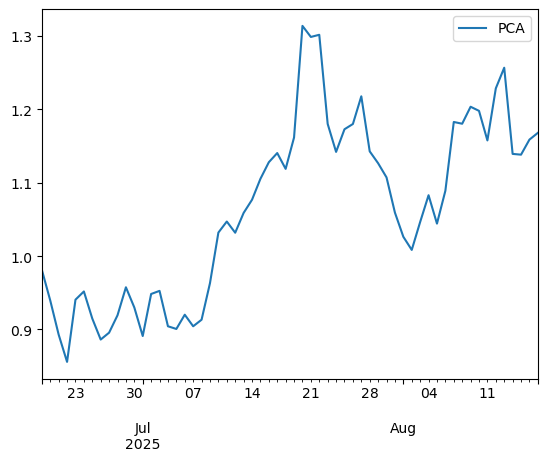

In [161]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

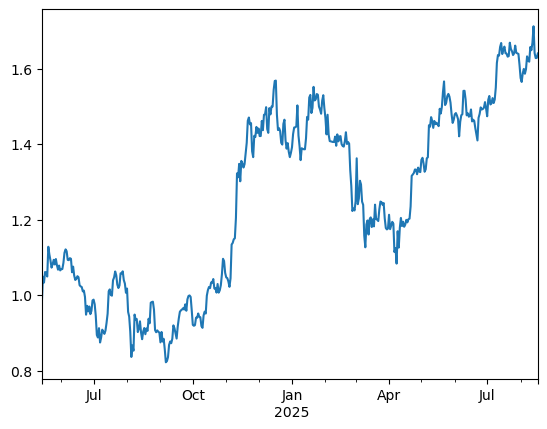

In [162]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [163]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.735526
SOLUSDT      0.773651
BTCUSDT      0.795665
BNBUSDT      0.798467
JASMYUSDT    0.976128
PEPEUSDT     1.011047
PAXGUSDT     1.058884
BBUSDT       1.080410
TRXUSDT      1.176749
dtype: float64

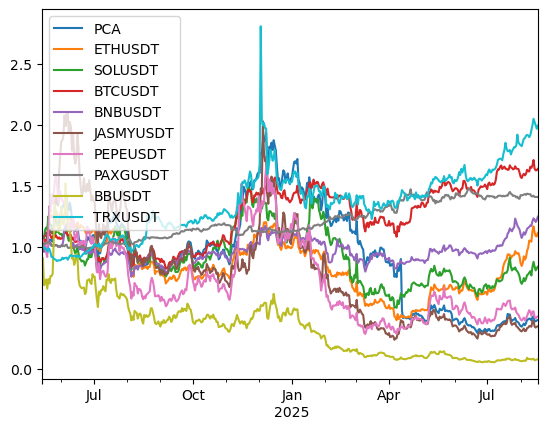

In [164]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [166]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.919450
BBUSDT       1.642926
JASMYUSDT    1.469224
SOLUSDT      1.286821
ETHUSDT      1.094607
BTCUSDT      1.000000
OMUSDT       0.993330
BNBUSDT      0.663610
TRXUSDT      0.332012
PAXGUSDT     0.028527
Name: BTCUSDT, dtype: float64

In [167]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       3.938024
JASMYUSDT    2.340683
SOLUSDT      1.960290
PEPEUSDT     1.929166
ETHUSDT      1.492137
OMUSDT       1.080110
BTCUSDT      1.000000
BNBUSDT      0.968166
TRXUSDT      0.467026
PAXGUSDT     0.098486
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [169]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [170]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
PEPEUSDT,0.291014
BNBUSDT,0.187477
TRXUSDT,0.174784
SOLUSDT,0.119896
ETHUSDT,0.102631
JASMYUSDT,0.090944
OMUSDT,0.083886
BBUSDT,0.062223
PAXGUSDT,-0.007040
BTCUSDT,-0.087331


### Regression to PCA

In [172]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.4627849636412376

In [173]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.316285
BNBUSDT      1.131098
PCA          1.000000
ETHUSDT      0.872433
SOLUSDT      0.728483
JASMYUSDT    0.467076
PEPEUSDT     0.459088
BBUSDT       0.370496
TRXUSDT      0.286842
PAXGUSDT     0.234081
OMUSDT       0.161213
dtype: float64

In [174]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.673216
BNBUSDT      1.333370
PAXGUSDT     1.205027
PCA          1.000000
ETHUSDT      0.934973
SOLUSDT      0.770294
PEPEUSDT     0.738627
JASMYUSDT    0.631787
TRXUSDT      0.498333
BBUSDT       0.269637
OMUSDT       0.263094
dtype: float64

### Correlation Matrix

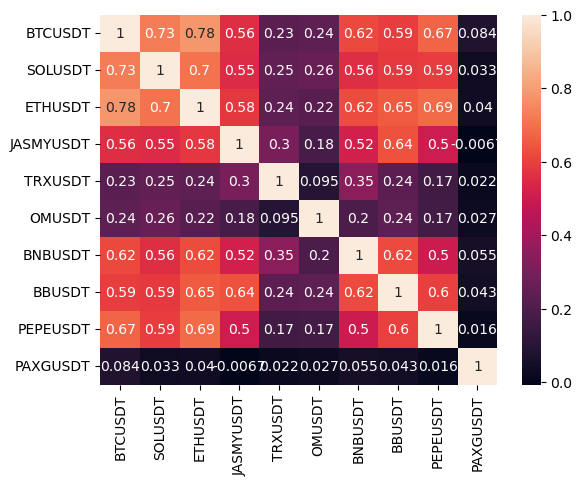

In [176]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

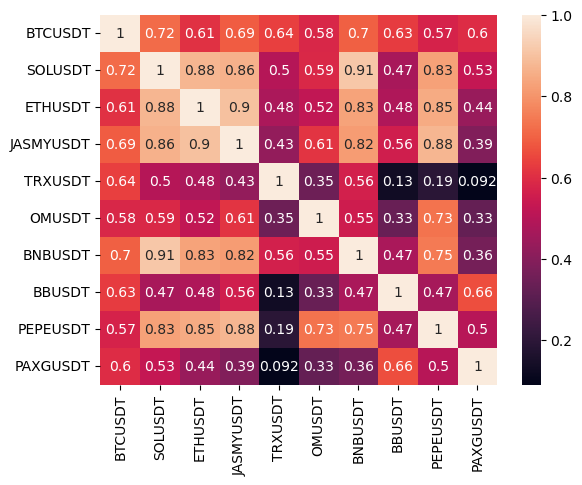

In [177]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [178]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [179]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

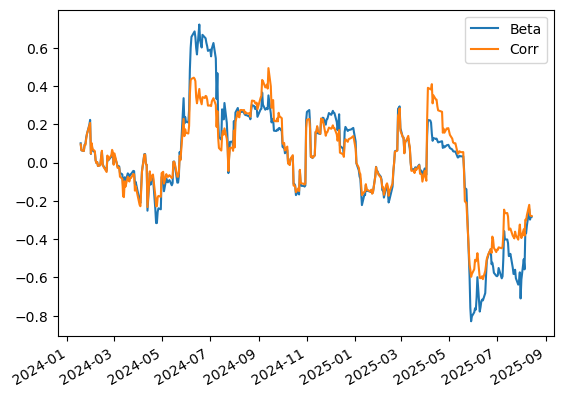

In [180]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [182]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,SOLUSDT,ETHUSDT,JASMYUSDT,TRXUSDT,OMUSDT,BNBUSDT,BBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.000000,0.000000,0.000000,0.150876,0.222957,0.626168,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.223616,0.000000,0.000000,0.003604,0.000000,0.772780
2024-07-22,0.260704,0.086231,0.000000,0.000000,0.238042,0.019283,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.453780,0.000000,0.000000,0.000000,0.000000,0.546220
2024-09-02,0.000000,0.000000,0.000000,0.000000,0.564814,0.435186,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.000000,0.000000,0.166022,0.000000,0.526887,0.176734,0.000000,0.000000,0.130357,0.000000


In [183]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [184]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,ADAUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,HBARUSDT,JASMYUSDT,LINKUSDT,...,OMUSDT,PAXGUSDT,PEPEUSDT,SOLUSDT,SUIUSDT,TRXUSDT,USDCUSDT,WBTCUSDT,XLMUSDT,XRPUSDT
2025-01-09,0.106751,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.893249,0.000000,0.0,0.0,0.00000,0.0
2025-02-08,0.106751,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.893249,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0
2025-03-10,1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0
2025-04-09,0.106751,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.843941,0.049308,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0
2025-05-09,0.106751,0.0,0.004312,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.582500,0.000000,0.040271,0.087033,0.085708,0.0,0.0,0.00000,0.0
2025-06-08,0.106751,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.893249,0.0,0.0,0.00000,0.0
2025-07-08,0.106751,0.0,0.893249,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0
2025-08-07,0.106751,0.0,0.000000,0.0,0.0,0.0,0.260395,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.474086,0.0,0.0,0.01229,0.0
2025-08-17,0.884349,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.115651,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0


In [185]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

TRXUSDT    0.474086
ETHUSDT    0.260395
LTCUSDT    0.146479
ADAUSDT    0.106751
XLMUSDT    0.012290
BTCUSDT    0.000000
Name: 2025-08-07 00:00:00, dtype: float64

<Axes: >

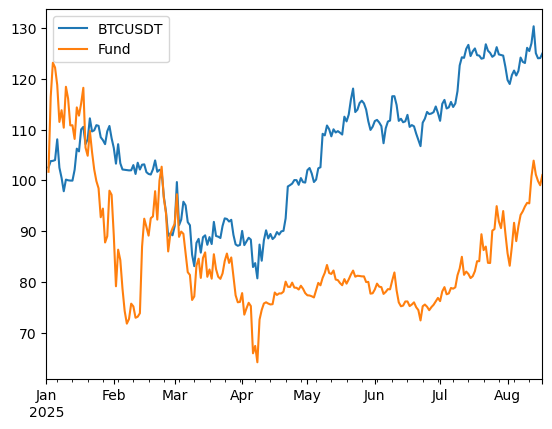

In [186]:
q=rebalanced_dynamic_quantities(data[returns_to_use.columns],rolling_optimization)
ptf=q*data[returns_to_use.columns]
comparison=pd.DataFrame()
comparison['BTCUSDT']=data['BTCUSDT']
comparison['Fund']=ptf.sum(axis=1)
((1+comparison.loc['2025'].pct_change()).cumprod()*100).plot()

In [187]:
(ptf-rebalanced_book_cost(data[returns_to_use.columns],q)).iloc[-1].sort_values(ascending=False)

SUIUSDT      378.868570
BCHUSDT       76.102775
OMUSDT        31.778962
PAXGUSDT      31.659019
ETHUSDT       26.220453
TRXUSDT       25.264768
PEPEUSDT      18.492283
XRPUSDT        0.000000
AVAXUSDT       0.000000
USDCUSDT       0.000000
LINKUSDT       0.000000
JASMYUSDT      0.000000
HBARUSDT       0.000000
DOGEUSDT       0.000000
BTCUSDT        0.000000
BNBUSDT        0.000000
WBTCUSDT       0.000000
XLMUSDT       -0.161670
SOLUSDT       -2.585378
ADAUSDT       -4.339307
LTCUSDT       -7.224347
Name: 2025-08-17 00:00:00, dtype: float64

In [188]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
